In [ ]:
!pip install datasets

In [1]:
from datasets import load_dataset

In [2]:
# Load WikiText-2
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Convert each split's 'text' column to a Python list
train_text = dataset['train']['text']
valid_text = dataset['validation']['text']
test_text  = dataset['test']['text']

# Join them into one big string
text_data = "\n".join(list(train_text) + list(valid_text) + list(test_text))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [3]:
print("Total characters:", len(text_data))
print(text_data[:500])  # Preview

Total characters: 13365597

 = Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [5]:
MAX_VOCAB = 20000   # limit vocab size
MAX_LEN = 100       # max sequence length
EMB_DIM = 50        # smaller embedding
LSTM_UNITS = 64     # smaller LSTM

lines = text_data.split('\n')

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(lines)

In [6]:
len(tokenizer.word_index) #unique words

72744

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create sequences
input_sequences = []
for sentence in text_data.split('\n'):
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(tokenized_sentence)):
        input_sequences.append(tokenized_sentence[:i+1])

In [8]:
import numpy as np

# Pad sequences
input_sequences = pad_sequences(input_sequences, maxlen=MAX_LEN, padding='pre')

# Convert to numpy array
input_sequences = np.array(input_sequences)

# Split into features (X) and label (y)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]


In [9]:
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

In [10]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Vocab size:", vocab_size)

Shape of X: (2123730, 99)
Shape of y: (2123730,)
Vocab size: 20000


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM , Dense
from tensorflow.keras.layers import Input

In [12]:
model = Sequential()
model.add(Input(shape=(MAX_LEN - 1,)))
model.add(Embedding(vocab_size, EMB_DIM))
model.add(LSTM(LSTM_UNITS))
model.add(Dense(vocab_size, activation='softmax'))

In [13]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 99, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20000)          │     1,300,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,329,440 (8.89 MB)

 Trainable params: 2,329,440 (8.89 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(X, y, epochs=10, validation_split=0.2)

Epoch 1/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 542s 10ms/step - accuracy: 0.2124 - loss: 5.2443 - val_accuracy: 0.1920 - val_loss: 5.8361
Epoch 2/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 560s 10ms/step - accuracy: 0.2139 - loss: 5.2075 - val_accuracy: 0.1886 - val_loss: 5.9172
Epoch 3/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 568s 10ms/step - accuracy: 0.2152 - loss: 5.1919 - val_accuracy: 0.1871 - val_loss: 5.9908
Epoch 4/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 548s 10ms/step - accuracy: 0.2167 - loss: 5.1631 - val_accuracy: 0.1861 - val_loss: 6.0315
Epoch 5/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 551s 10ms/step - accuracy: 0.2166 - loss: 5.1516 - val_accuracy: 0.1843 - val_loss: 6.0642
Epoch 6/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 553s 10ms/step - accuracy: 0.2178 - loss: 5.1413 - val_accuracy: 0.1835 - val_loss: 6.1185
Epoch 7/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 572s 10ms/step - accuracy: 0.2181 - loss: 5.1355 - val_accuracy: 0.1816 - val_loss: 6.1461
Epoch 8/10
53094/53094 ━━━━━━━━━━━━━━━━━━━━ 559s 10ms/s

In [54]:
import time

text = 'Valkyria'

for i in range(15):
  #tokenize
  tokenized_text = tokenizer.texts_to_sequences([text])[0]

  #padding
  padded_token_text = pad_sequences([tokenized_text], maxlen=MAX_LEN-1, padding='pre')

  #predict
  predicted_id = np.argmax(model.predict(padded_token_text), axis=-1)[0]

  # Map ID to word
  predicted_word = tokenizer.index_word.get(predicted_id, '')

  # Append predicted word to the text
  if predicted_word:
      text = text + " " + predicted_word
      print(text)
      time.sleep(0.5)
  else:
      break # stop if no prediction found

print("\nFinal Generated text:" , text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Valkyria chronicles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Valkyria chronicles iii
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Valkyria chronicles iii was
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Valkyria chronicles iii was released
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Valkyria chronicles iii was released on
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Valkyria chronicles iii was released on the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Valkyria chronicles iii was released on the playstation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Valkyria chronicles iii was released on the playstation 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Valkyria chronicles iii was released on the playstation 2 playstation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Valkyria chronicles iii was released on the playstation 2 playstation 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Valkyria chronicles iii was released on the playstation 2 playstation 3 playstation
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Valkyria ch

In [55]:
import matplotlib.pyplot as plt

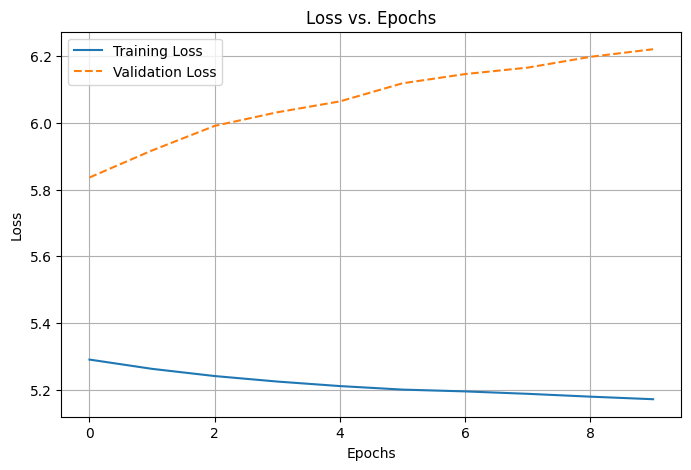

In [60]:
#Loss Vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

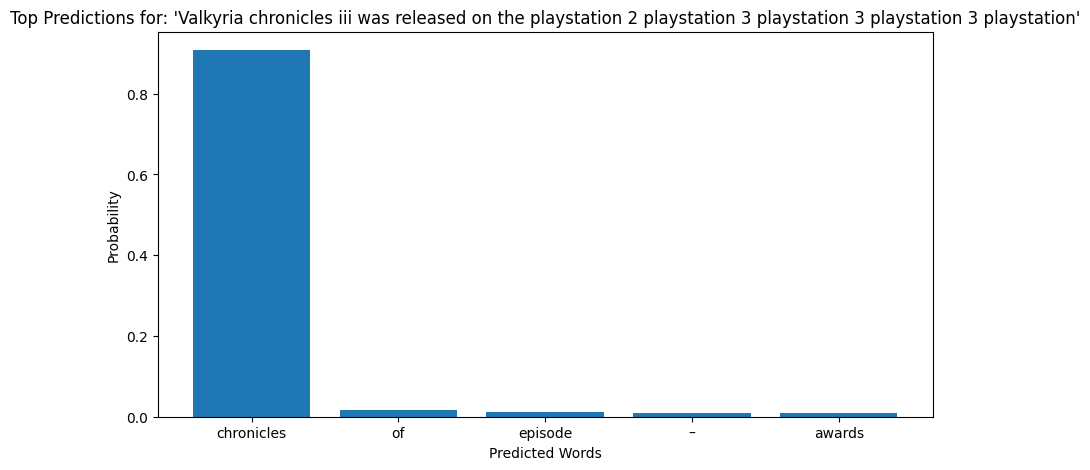

In [62]:
## Get top 5 predicted words
plt.figure(figsize=(10, 5))
plt.bar(top_words, top_probs)
plt.xlabel('Predicted Words')
plt.ylabel('Probability')
plt.title(f"Top Predictions for: '{text}'")
plt.show()

/tmp/ipython-input-3839415828.py:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


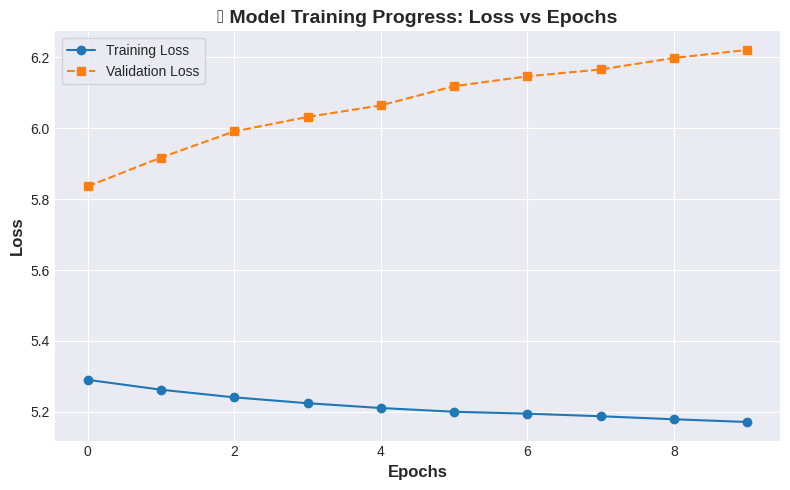

In [63]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')  # Elegant theme

# Training history plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], marker='o', color='#1f77b4', label='Training Loss')
plt.plot(history.history['val_loss'], marker='s', color='#ff7f0e', label='Validation Loss', linestyle='--')

plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('📉 Model Training Progress: Loss vs Epochs', fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2715153430.py:13: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) Liberation Sans.
  plt.tight_layout()


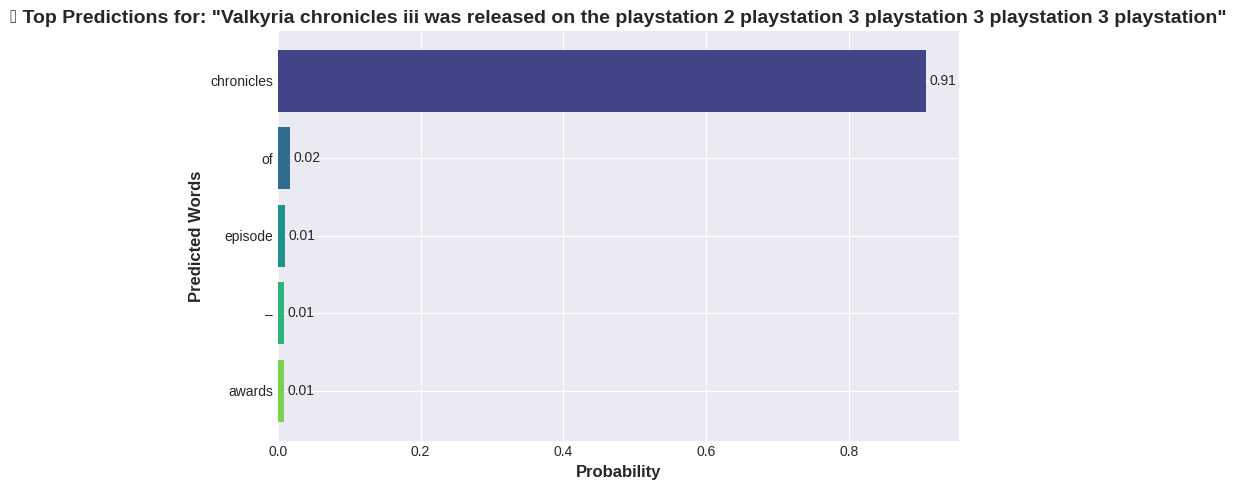

In [65]:
# Plot
plt.figure(figsize=(8, 5))
bars = plt.barh(top_words, top_probs, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_words))))
plt.xlabel('Probability', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Words', fontsize=12, fontweight='bold')
plt.title(f'🔮 Top Predictions for: "{text}"', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add probability annotations
for bar, prob in zip(bars, top_probs):
    plt.text(prob + 0.005, bar.get_y() + bar.get_height()/2, f"{prob:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()
